In [1]:
# from google.colab import drive
# import re
# drive.mount('/content/drive')

In [2]:
# !tar -xzvf "/content/drive/MyDrive/CENG_483/HW_3/the3_data.tar.gz" -C "/content/drive/MyDrive/CENG_483/HW_3/"

In [3]:
# !tar -xzvf "/content/drive/MyDrive/CENG_483/HW_3/src.tar.gz" -C .

In [4]:
# --- imports ---
from ast import With
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision.utils import save_image
import imageio
from PIL import Image

import hw3utils
torch.multiprocessing.set_start_method('spawn', force=True)

In [5]:
# Feel free to change / extend / adapt this source code as needed to complete the homework, based on its requirements.
# This code is given as a starting point.
#
# REFEFERENCES
# The code is partly adapted from pytorch tutorials, including https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# ---- hyper-parameters ----
# You should tune these hyper-parameters using:
# (i) your reasoning and observations, 
# (ii) by tuning it on the validation set, using the techniques discussed in class.
# You definitely can add more hyper-parameters here.

batch_size = 16
max_num_epoch = 100
hps = {'lr':0.1}

# ---- options ----
DEVICE_ID = 'cuda:0' # set to 'cpu' for cpu, 'cuda' / 'cuda:0' or similar for gpu.
# device = torch.device(DEVICE_ID)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ' + str(device))

# Experiment desription
EXP = 'best_config_epoch_mech_12margin_8'
LOG_DIR = 'checkpoints_'+ EXP

VISUALIZE = False # set True to visualize input, prediction and the output from the last batch
LOAD_CHKPT = False

device: cuda:0


In [6]:
# Seed to ensure deterministic behavior
import random
from tqdm.notebook import tqdm
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [7]:
# !pip install wandb --upgrade

In [8]:
import wandb

wandb.login()

wandb: Currently logged in as: alpayozkan (use `wandb login --relogin` to force relogin)


True

In [9]:
config = dict(
    epochs=max_num_epoch,
    batch_size=batch_size,
    learning_rate=hps['lr'],
    architecture="CNN")

In [10]:
def model_pipeline(hyperparameters):

      # start wandb
      wandb.init(project="vision", entity="alpayozkan", config=hyperparameters)
      
      # wandb.config => hyperparameters
      config = wandb.config

      # create model, data, and optimization problem
      model, train_loader, valid_loader, test_loader, criterion, optimizer = make(config)
      print(model)
      
      # use them to train the model
      train(model, train_loader, valid_loader, criterion, optimizer, config)

      # test its final performance, save .npy estimations
      test(model, test_loader)

      return model

In [11]:
def make(config):
    # ---- training code -----
    
    
    # Make the model
    model = Net().to(device=device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)
    
    # Make the data
    train_loader, valid_loader, test_loader = get_loaders(config.batch_size, device)

    return model, train_loader, valid_loader, test_loader, criterion, optimizer

In [12]:
# ---- utility functions -----
def get_loaders(batch_size,device):
    data_root = '../../ceng483-s19-hw3-dataset' # modified this otherwise received error
    
    train_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'train'),device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    
    valid_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'val'),device=device)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # save test images as 2000x1x80x80 tensor
    test_path = data_root + "/test_inputs/"
    convert_tensor = transforms.ToTensor()
    test_loader = torch.stack([convert_tensor(Image.open(test_path+str(i)+".jpg")) for i in range(2000)])
    
    # scale test from [0,1] => [-1,1]
    test_loader = (test_loader-0.5)*2
    test_loader = test_loader.reshape(2000,1,1,80,80) # batch_size=1, indiv predictions

    return train_loader, valid_loader, test_loader

In [13]:
# ---- ConvNet -----
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # burda en fazla 4 conv ?
        # fcc ?
        # network 3-4 conv la bu task i cozebilecek mi, baktigim paperdaki network cok daha complex idi
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 3, 5, padding=2)
        # self.conv3 = nn.Conv2d(8, 8, 5, padding=2)
        # self.conv4 = nn.Conv2d(8, 3, 5, padding=2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.conv1_bn = nn.BatchNorm2d(8)
        # self.conv2_bn = nn.BatchNorm2d(8)
        # self.conv3_bn = nn.BatchNorm2d(8)

    def forward(self, grayscale_image):
        # apply your network's layers in the following lines:      
        x = self.relu(self.conv1(grayscale_image))
        x = self.tanh(self.conv2(x))
        # x = self.relu(self.conv3(x))
        # x = self.conv4(x)
        return x

In [14]:
def scale_output0255(output):
    return (output/2 + 0.5)*255 # scales [-1,1] => [0,1] => [0,255]

def scale_output01(output):
    return (output/2 + 0.5) # scales [-1,1] => [0,1] => [0,255]

In [15]:
def train(model, train_loader, valid_loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(train_loader) * config.epochs
    
    # early-stop paramters
    toler = 0  # track toleration
    epsilon = 5e-6 # epsilon change
    patience = 5 # patience
    loss_valid_prev = np.inf # prev-valid-loss keep track
    
    print('training begins')
    for epoch in tqdm(range(config.epochs)):
        loss_valid_c = 0
        loss_train_c = 0

        example_ct_train = 0  # number of examples seen Train
        example_ct_valid = 0  # number of examples seen Valid
        batch_ct_train = 0
        batch_ct_valid = 0
        
        loss_12margin_train = 0 # 12-margin train error
        loss_12margin_valid = 0 # 12-margin valid error
        
        model.train()
        for _, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
    
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train = loss
            # loss_train = train_batch(images, labels, model, optimizer, criterion)
            loss_train_c += loss_train.item() 
            example_ct_train +=  len(images)
            batch_ct_train += 1
            
            # scale outputs, labels => [-1,1] => [0,1] => [0,255]
            outputs_scaled01 = scale_output01(outputs)
            outputs_scaled0255 = scale_output0255(outputs)
            labels_scaled01 = scale_output01(labels)
            labels_scaled0255 = scale_output0255(labels)
            
            # uint8 [0.255]
            # outputs_scaled0255 = outputs_scaled0255.type(torch.uint8)
            # labels_scaled0255 = labels_scaled0255.type(torch.uint8)
            
            # convert to numpy
            # outputs_scaled = outputs_scaled.numpy().astype(np.int64).reshape(-1,80,80,3)
            # labels_scaled = labels_scaled.numpy().astype(np.int64).reshape(-1,80,80,3)
            
            # dimension check in case
            D = outputs_scaled01.shape
            D = D[1]*D[2]*D[3]
            assert D==80*80*3
            
            # 12-margin train error
            loss_12margin_train += torch.sum(torch.abs(outputs_scaled0255-labels_scaled0255)>=12) / D
            
            #  if ((batch_ct + 1) % 25) == 0:
            #     train_log(train_loss, example_ct, epoch)
        
        model.eval()
        with torch.no_grad():
          for batch_idx, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)
           
            predicted = model(images)
            loss = criterion(predicted, labels)

            loss_valid = loss
            # loss_valid = valid_batch(images, labels, model, criterion)
            loss_valid_c += loss_valid.item()

            example_ct_valid +=  len(images)
            batch_ct_valid += 1
            
            # scale outputs, labels => [-1,1] => [0,1] => [0,255]
            predicted_scaled01 = scale_output01(predicted) # (16,3,80,80)
            predicted_scaled0255 = scale_output0255(predicted) # (16,3,80,80)
            labels_scaled01 = scale_output01(labels) # (16,3,80,80)
            labels_scaled0255 = scale_output0255(labels) # (16,3,80,80)
            
            # uint8 [0.255]
            # predicted_scaled0255 = predicted_scaled0255.type(torch.uint8)
            # labels_scaled0255 = labels_scaled0255.type(torch.uint8)
            
            # convert to numpy
            # predicted_scaled = predicted_scaled.numpy().astype(np.int64).reshape(-1,80,80,3)
            # labels_scaled = labels_scaled.numpy().astype(np.int64).reshape(-1,80,80,3)
            
            # dimension check in case
            D = predicted_scaled01.shape
            D = D[1]*D[2]*D[3]
            assert D==80*80*3
            
            # 12-margin valid error
            loss_12margin_valid += torch.sum(torch.abs(predicted_scaled0255-labels_scaled0255)>=12) / D # per pixel for the whole batch
            
            # save qualitative images from valid set, 1 img for each batch sufficient
            img_pred = predicted_scaled01[0]
            img_label = labels_scaled01[0]
            
            path_valid_imgs = LOG_DIR + "/valid_imgs/" 
            path_pred = path_valid_imgs + "img_pred_" + str(epoch+1) + "_" + str(batch_idx) + ".png"
            path_label = path_valid_imgs + "img_label_" + str(epoch+1) + "_" + str(batch_idx) + ".png"
            
            if not os.path.exists(path_valid_imgs):
                os.makedirs(path_valid_imgs)
            
            # imageio.imwrite(path_pred, img_pred)
            # imageio.imwrite(path_label, img_label)
            print(img_pred.shape)
            print(img_pred.reshape(80,80,3).shape)
            save_image(img_pred, path_pred)
            save_image(img_label, path_label)
            
        
        # per image avg mse losss    
        loss_train = loss_train_c / example_ct_train
        loss_valid = loss_valid_c / example_ct_valid
        
        # per image avg 12-margin losss
        loss_12margin_train = loss_12margin_train / example_ct_train
        loss_12margin_valid = loss_12margin_valid / example_ct_valid
        
        loss_diff = loss_valid-loss_train
        loss_valid_diff = loss_valid-loss_valid_prev
        
        loss_log(loss_train, loss_valid, loss_diff, loss_valid_diff, \
                 loss_12margin_train, loss_12margin_valid, epoch)


        print('Saving the model, end of epoch %d' % (epoch+1))
        if not os.path.exists(LOG_DIR):
            os.makedirs(LOG_DIR)
        torch.save(model.state_dict(), os.path.join(LOG_DIR,'checkpoint_' + str(epoch+1) + '.pt'))
        hw3utils.visualize_batch(images, labels, predicted , os.path.join(LOG_DIR,'example' + str(epoch+1) + '.png'))
        
        # early-stopping mechanism
        # patience and epsilon: determines when to stop
        # track loss_valid-loss_train
        if loss_valid_diff>-epsilon:
            if toler==patience:
                # stop training
                # load model when patience=0, patience time before
                print('Early Stopping at epoch: %d' % (epoch+1))
                
                checkpoint_file = os.path.join(LOG_DIR,'checkpoint_' + str(epoch+1-patience) + '.pt')
                print('Loading: ' + checkpoint_file)
                
                checkpoint = torch.load(checkpoint_file)
                model.load_state_dict(checkpoint)
                break
            else:
                toler +=1 
        else:
            toler=0
        loss_valid_prev = loss_valid
        
    print('Finished Training')

def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    return loss


def valid_batch(images, labels, model, criterion):
    images, labels = images.to(device), labels.to(device)
    predicted = model(images)
    loss = criterion(predicted, labels)
    return loss


In [16]:
def loss_log(loss_train, loss_valid, loss_diff, loss_valid_diff, loss_12margin_train, loss_12margin_valid, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch+1, "train_loss": loss_train, "valid_loss": loss_valid, \
               "valid-train_diff": loss_diff, "loss_valid_diff": loss_valid_diff, \
               "loss_12margin_train": loss_12margin_train, "loss_12margin_valid": loss_12margin_valid})
    
    print(f"Epochs " + str(epoch+1) + f" Train loss: {loss_train:.5f}" + f" Valid loss: {loss_valid:.5f}" + \
          f" Valid-Train Diff: {loss_diff:.5f}" + f" Loss-Valid Diff: {loss_valid_diff:.5f}" + \
          f" Loss-12margin Train: {loss_12margin_train:.5f}" + f" Loss-12margin Valid: {loss_12margin_valid:.5f}")

In [17]:
def test(model, test_loader):
    model.eval()
    
    # Run the model on some test examples
    estimations = []
    with torch.no_grad():
        for idx,image in enumerate(test_loader): # we dont have any labels, just estimations
            image = image.to(device)
            output = model(image)
    
            scaled_output01 =scale_output01(output) # 1,3,80,80
            scaled_output0255 =scale_output0255(output) # 1,3,80,80
        
            predicted_scaled0255 = scaled_output0255.cpu().numpy().astype(np.uint8).reshape(-1,80,80,3)
            estimations.append(predicted_scaled0255)
        
            img_pred = scaled_output01[0] # 3,80,80
        
            path_test_imgs = LOG_DIR + "/test_imgs/" 
            path_test = path_test_imgs + "img_test_" + str(idx) + ".png"
            
            if not os.path.exists(path_test_imgs):
                os.makedirs(path_test_imgs)
            
            save_image(img_pred, path_test)

    estimations = np.vstack(estimations)

    estimations = estimations.reshape(2000,3,80,80)
    estim = np.transpose(estimations, (0,2,3,1))
    estim = estim[:, :, :, ::-1]

    np.save(LOG_DIR + '/estimations_test.npy', estim)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (tanh): Tanh()
)
training begins


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 7 Train loss: 0.00059 Valid loss: 0.00060 Valid-Train Diff: 0.00000 Loss-Valid Diff: -0.00001 Loss-12margin Train: 0.26302 Loss-12margin Valid: 0.25903
Saving the model, end of epoch 7
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 11 Train loss: 0.00056 Valid loss: 0.00057 Valid-Train Diff: 0.00001 Loss-Valid Diff: -0.00000 Loss-12margin Train: 0.25224 Loss-12margin Valid: 0.25158
Saving the model, end of

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 15 Train loss: 0.00055 Valid loss: 0.00055 Valid-Train Diff: 0.00000 Loss-Valid D

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 19 Train loss: 0.00054 Valid loss: 0.00055 Valid-Train Diff: 0.00001 Loss-Valid Diff: -0.00000 Loss-12margin Train: 0.24498 Loss-12margin Valid: 0.24174
Saving the model, end of epoch 19
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

Epochs 26 Train loss: 0.00053 Valid loss: 0.00054 Valid-Train Diff: 0.00000 Loss-Valid Diff: -0.00002 Loss-12margin Train: 0.24167 Loss-12margin Valid: 0.23639
Saving the model, end of epoch 26
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 33 Train loss: 0.00053 Valid loss: 0.00059 Valid-Train Diff: 0.00006 Loss-Valid Diff: 0.00005 Loss-12margin Train: 0.23924 Loss-12margin Valid: 0.26514
Saving the model, end of epoch 33
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80,

torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 8

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 37 Train loss: 0.00053 Valid loss: 0.00053 Valid-Train Diff: 0.00000 Loss-Valid Diff: 0.00000 Loss-12margin Train: 0.23895 Loss-12margin Valid: 0.23367
Saving the model, end of epoch 37
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80,

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 

torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
torch.Size([3, 80, 80])
torch.Size([80, 80, 3])
Epochs 56 Train loss: 0.00052 Valid loss: 0.00053 Valid-Train Diff: 0.00001 Loss-Valid Diff: 0.00000 Loss-12margin Train: 0.23539 Loss-12margin Valid: 0.23379
Saving the model, end of epoch 56
Early Stopping at epoch: 56
Loading: checkpoints_best_config_epoch_mech_12margin_8/checkpoint_51.pt
Finished Training


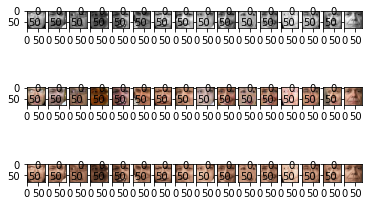

In [18]:
model = model_pipeline(config)

In [19]:
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (tanh): Tanh()
)

In [20]:
# from cv2 import cv2
# cv2.imshow('ex', tmp[1])
# cv2.destroyAllWindows()

In [21]:
tmp=np.load(LOG_DIR + '/estimations_test.npy')

In [22]:
#img = Image.fromarray(tmp[1], 'RGB')
# img.save('my.png')
# img.show()